## Transfer Learning RestNet50 for 2 classes

In [63]:

train_path = "data/split/train/"
test_path = "data/split/test/"
val_path = "data/split/val/"

In [65]:

train_generator_bi = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.3)
val_generator_bi = ImageDataGenerator(rescale=1./255)
test_generator_bi= ImageDataGenerator(rescale=1./255)

In [73]:
train_bi = train_generator_bi.flow_from_directory(train_path,
                                               batch_size=3514,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 3514 images belonging to 2 classes.


In [74]:
val_bi = val_generator_bi.flow_from_directory(val_path,
                                               batch_size=1172,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 1172 images belonging to 2 classes.


In [75]:
test_bi = test_generator_bi.flow_from_directory(test_path,
                                          batch_size=1172,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 1170 images belonging to 2 classes.


In [93]:
print(train_bi.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [76]:
train_images_bi, train_labels_bi = next(train_bi )
test_images_bi, test_labels_bi = next(test_bi )
val_images_bi, val_labels_bi = next(val_bi )

In [77]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

In [78]:
np.random.seed(123)
model_bi = Sequential()

model_bi.add(resnet50)    
model_bi.add(Flatten())
model_bi.add(Dense(units = 128, activation = "relu"))
model_bi.add(Dropout(0.5))

model_bi.add(Dense(units = 1, activation = "sigmoid"))

In [79]:
resnet50.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model2.trainable_weights))

flatten_5 True
dense_13 True
dropout_6 True
dense_14 True
dropout_7 True
dense_15 True
6


In [83]:
model_bi.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

In [84]:
history_bi = model_bi.fit(train_images_bi, train_labels_bi, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images_bi , val_labels_bi))

Epoch 1/10
110/110 [==============================] - 336s 3s/step - loss: 0.2994 - acc: 0.9007 - val_loss: 0.1754 - val_acc: 0.9292
Epoch 2/10
110/110 [==============================] - 334s 3s/step - loss: 0.2279 - acc: 0.8949 - val_loss: 0.2167 - val_acc: 0.9249
Epoch 3/10
110/110 [==============================] - 329s 3s/step - loss: 0.1702 - acc: 0.9351 - val_loss: 0.1553 - val_acc: 0.9445
Epoch 4/10
110/110 [==============================] - 1550s 14s/step - loss: 0.1617 - acc: 0.9452 - val_loss: 0.2043 - val_acc: 0.9445
Epoch 5/10
110/110 [==============================] - 3285s 30s/step - loss: 0.1173 - acc: 0.9507 - val_loss: 0.2173 - val_acc: 0.9488
Epoch 6/10
110/110 [==============================] - 338s 3s/step - loss: 0.1017 - acc: 0.9532 - val_loss: 0.3996 - val_acc: 0.9027
Epoch 7/10
110/110 [==============================] - 332s 3s/step - loss: 0.1025 - acc: 0.9495 - val_loss: 0.3460 - val_acc: 0.9147
Epoch 8/10
110/110 [==============================] - 327s 3s/ste

In [87]:
model_bi.evaluate( 
    test_images_bi , test_labels_bi, batch_size=50, verbose=1)

24/24 [==============================] - 86s 4s/step - loss: 0.2550 - acc: 0.9444


[0.2549922466278076, 0.9444444179534912]

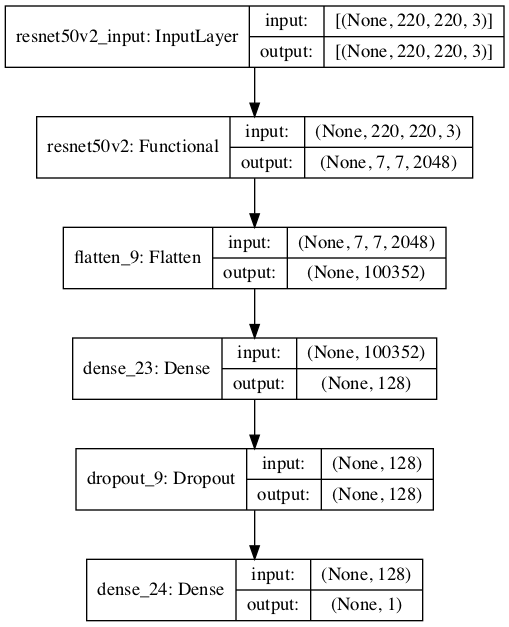

In [89]:
tf.keras.utils.plot_model(
    model_bi, to_file='images/model_bi_transfer_network.png', show_layer_names=True, show_shapes=True)

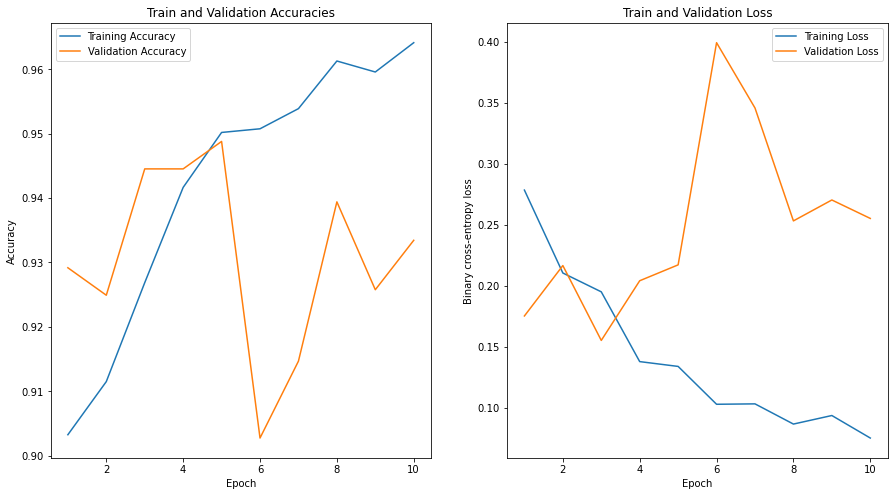

In [90]:
vis.plot_loss_accuracy(history_bi)
plt.savefig('images/transfer_model.png')
plt.show()

<AxesSubplot:>

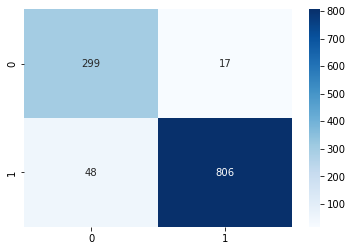

In [91]:
test_pred_labels = (model_bi.predict(test_images_bi) > 0.5).astype('int32')
test_cm = confusion_matrix(test_labels_bi, test_pred_labels)
sns.heatmap(data=test_cm,cmap='Blues',annot=True, fmt='d')


In [94]:
classification_metrics= classification_report(test_labels_bi,test_pred_labels, target_names=['NORMAL', 'PNEUMONIA'])
print(classification_metrics)

              precision    recall  f1-score   support

      NORMAL       0.86      0.95      0.90       316
   PNEUMONIA       0.98      0.94      0.96       854

    accuracy                           0.94      1170
   macro avg       0.92      0.94      0.93      1170
weighted avg       0.95      0.94      0.95      1170



In [ ]:
with open('models/model_transfer.pkl', 'wb') as f:
        pickle.dump(model_bi.history, f)

In [ ]:
model_bi.save('models/model_transfer.h5')